# 1. Load packages

In [1]:
from analysis_tools.common import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import sklearn
import cv2
import os

%load_ext autoreload
%autoreload 2

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
sklearn.random.seed(RANDOM_STATE)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Load dataset

In [2]:
from sklearn.preprocessing import OneHotEncoder

train_full_data_meta = pd.read_csv(join(PATH.input, 'train_df.csv'), index_col=0)
test_data_meta       = pd.read_csv(join(PATH.input, 'test_df.csv'), index_col=0)
n_classes            = train_full_data_meta.label.nunique()

with ProgressBar():
    X_train_full = compute(*[delayed(cv2.imread)(path) for path in ls_file(PATH.train)])
    X_test       = compute(*[delayed(cv2.imread)(path) for path in ls_file(PATH.test)])
y_train_full = train_full_data_meta[['label']]

y_enc        = OneHotEncoder(sparse=False, dtype=np.bool)
y_train_full = y_enc.fit_transform(y_train_full)

print("- Number of train full data:", len(X_train_full))
print("- Number of test data:", len(X_test))
print("- Number of classes:", n_classes)

[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  3.9s
- Number of train full data: 4277
- Number of test data: 2154
- Number of classes: 88


# 3. Modeling

In [3]:
IMG_SIZE    = 512
input_shape = (IMG_SIZE, IMG_SIZE, 3)

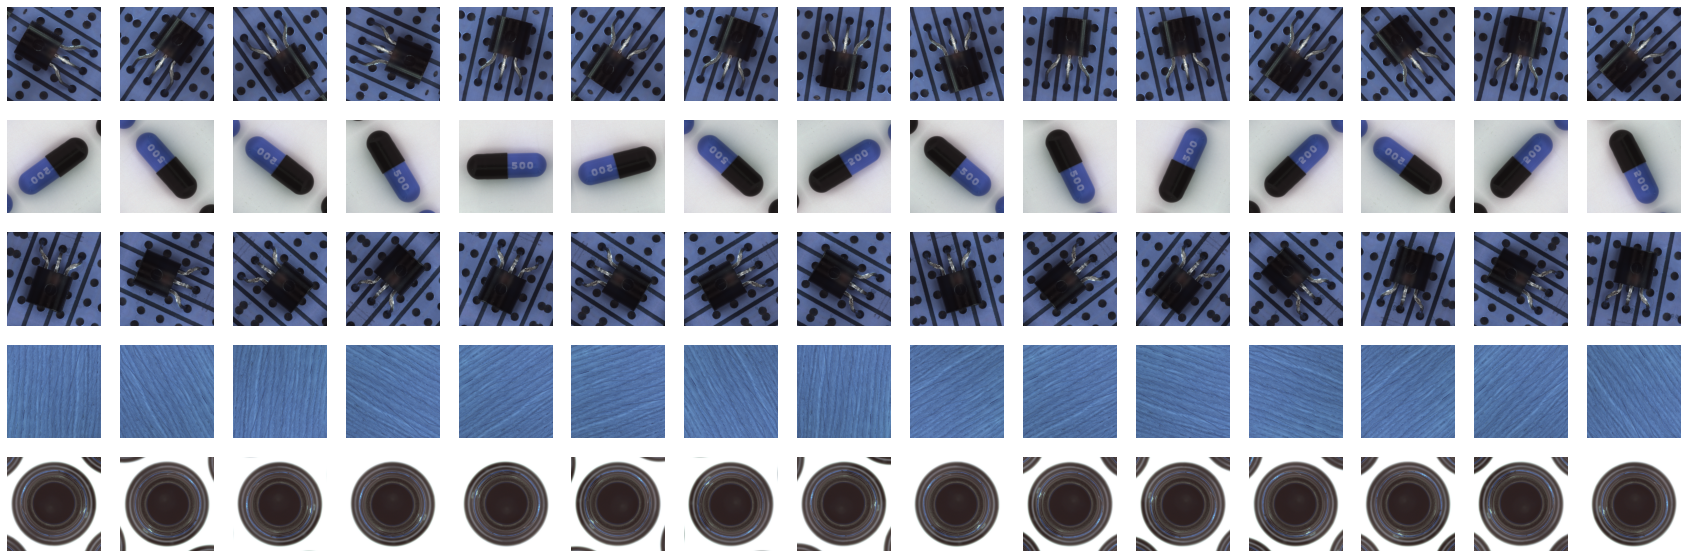

In [8]:
aug_model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

fig, axes = plt.subplots(5, 15, figsize=(30, 10))
for row, ax_cols in enumerate(axes):
    for ax in ax_cols:
        ax.imshow(aug_model(X_train_full[row]))
        ax.axis('off')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

with ProgressBar():
    X_train_full = np.array(compute(*[delayed(cv2.resize)(X, [IMG_SIZE, IMG_SIZE]) for X in X_train_full]))
    X_test       = np.array(compute(*[delayed(cv2.resize)(X, [IMG_SIZE, IMG_SIZE]) for X in X_test]))
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, stratify=y_train_full)

def preprocess(ds, training, batch_size, augment=True):
    ds = ds.cache().batch(batch_size)
    if training:
        ds = ds.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
        if augment:
            ds = ds.map(lambda X, y: (aug_model(X), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds

train_ds      = preprocess(tf.data.Dataset.from_tensor_slices((X_train, y_train)), True, BATCH_SIZE)
val_ds        = preprocess(tf.data.Dataset.from_tensor_slices((X_val, y_val)), False, BATCH_SIZE)
train_full_ds = preprocess(tf.data.Dataset.from_tensor_slices((X_train_full, y_train_full)), True, BATCH_SIZE)
test_ds       = preprocess(tf.data.Dataset.from_tensor_slices(X_test), False, BATCH_SIZE)

print("- train.shape:", X_train.shape, y_train.shape)
print("- train_full.shape:", X_train_full.shape, y_train_full.shape)
print("- val.shape:", X_val.shape, y_val.shape)
print("- test.shape:", X_test.shape)

[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  0.8s
- train.shape: (3207, 512, 512, 3) (3207, 88)
- train_full.shape: (4277, 512, 512, 3) (4277, 88)
- val.shape: (1070, 512, 512, 3) (1070, 88)
- test.shape: (2154, 512, 512, 3)


# 4. Training

In [10]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard

class LearningPlot(Callback):
    def __init__(self, plot_path, figsize=(15, 8)):
        self.plot_path  = plot_path
        self.figsize    = figsize
        self.metrics    = pd.DataFrame()
        self.best_epoch = -1
        mkdir(dirname(self.plot_path))
    def on_epoch_end(self, epoch, logs={}):
        self.metrics = self.metrics.append(logs, ignore_index=True)
        if 'val_loss' in self.metrics:
            self.best_epoch = np.argmin(self.metrics['val_loss'])
        self._save_fig(epoch)
    def _save_fig(self, epoch):
        fig, ax_loss = plt.subplots(figsize=self.figsize)
        ax_metric    = ax_loss.twinx()
        lns = []
        for col in self.metrics:
            ln = self.metrics[col].plot(color='r' if col.startswith('val') else 'b', linestyle='-' if col.startswith('loss') else '--', ax=ax_loss if 'loss' in col else ax_metric)
            lns.append(ln)
        if self.best_epoch != -1:
            ax_loss.axvline(self.best_epoch, color='k', ls=':', lw=3, label=f'best_epoch: {self.best_epoch}')
        ax_loss.set_xlabel('epoch')
        ax_loss.set_ylabel('loss');  ax_metric.set_ylabel('metric')
        ax_loss.set_yscale('log')
        ax_loss.legend(lns, [ln.get_label() for ln in lns], loc='upper center')
        fig.tight_layout()
        fig.savefig(f'{self.plot_path}.png')
        plt.close(fig)

## 4.1 Validation O

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs  = keras.Input(input_shape)
    hidden  = base_model(inputs, training=False)
    hidden  = keras.layers.GlobalAveragePooling2D()(hidden)
    outputs = keras.layers.Dense(n_classes, activation='softmax')(hidden)
    model   = keras.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=n_classes, average='macro')])

## 4.1.1 Fix pretrained model

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[EarlyStopping(patience=10, restore_best_weights=True), TensorBoard(join(PATH.root, 'tensorboard')), LearningPlot(join(PATH.result, 'proposed2', 'validation_fix_pretrained_model'))])

## 4.1.2 Fine-tuning (validation O)

In [ ]:
with strategy.scope():
    base_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(2e-4), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=n_classes, average='macro')])
history = model.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[EarlyStopping(patience=10, restore_best_weights=True), TensorBoard(join(PATH.root, 'tensorboard')), LearningPlot(join(PATH.result, 'proposed2', 'validation_fine_tuning'))])

In [ ]:
pred_test_validation = model.predict(test_ds)
pred_test_validation = y_enc.inverse_transform(pred_test_validation)

submission = pd.read_csv(join(PATH.input, 'sample_submission.csv'), index_col=0)
submission['label'] = pred_test_validation
submission.to_csv(join(PATH.output, 'proposed2_validation_on.csv'))
submission

In [ ]:
from dacon_submit_api.dacon_submit_api import post_submission_file

result = post_submission_file(
    'output/proposed2_validation_on.csv',
    '137ff236e305f302819b930b3b5b72e948603f23c5249a516c32b536d5187a03', 
    '235894', 
    '어스름한 금요일 밤에', 
    'proposed2_validation_on'
)

## 4.2 Validation X

## 4.2.1 Fix pretrained model

In [4]:
best_epochs = int(38 * (1/0.7))

In [6]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
    base_model.trainable = False

    inputs  = keras.Input(input_shape)
    hidden  = base_model(inputs, training=False)
    hidden  = keras.layers.GlobalAveragePooling2D()(hidden)
    outputs = keras.layers.Dense(n_classes, activation='softmax')(hidden)
    model   = keras.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=n_classes, average='macro')])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localho

In [11]:
history = model.fit(train_full_ds, epochs=best_epochs, callbacks=[TensorBoard(join(PATH.root, 'tensorboard')), LearningPlot(join(PATH.result, 'proposed2', 'fix_pretrained_model'))])

Epoch 1/54
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
134/134 [==============================] - 39s 97ms/step - loss: 1.2226 - f1_score: 0.1542
Epoch 2/54
134/134 [==============================] - 14s 75ms/step - loss: 0.6433 - f1_score: 0.1994
Epoch 3/54
134/134 [==============================] - 14s 74ms/step - loss: 0.5675 - f1_score: 0.2345
Epoch 4/54
134/134 [==============================] - 14s 73ms/step - loss: 0.5170 - f1_score: 0.2765
Epoch 5/54
134/134 [==============================] - 14s 74ms/step - loss: 0.4781 - f1_score: 0.3089
Epoch 6/54
134/134 [==============================] - 14s 74ms/step - loss: 0.4431 - f1_score: 0.3563
Epoch 7/54
134/134 [==============================] - 13s 74ms/step - loss: 0.4185 - f1_score: 0.3654
Epoch 8/54
134/134 [==============================] - 14s 75ms/step - loss: 0.4007 - f1_score: 0.4038
Epoch 9/54
134

## 4.2.2 Fine-tuning

In [12]:
best_epochs = int(6 * (1/0.7))

In [13]:
with strategy.scope():
    base_model.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(2e-4), loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=n_classes, average='macro')])
history = model.fit(train_ds, validation_data=val_ds, epochs=best_epochs, callbacks=[EarlyStopping(patience=10, restore_best_weights=True), TensorBoard(join(PATH.root, 'tensorboard')), LearningPlot(join(PATH.result, 'proposed2', 'fine_tuning'))])

Epoch 1/8
INFO:tensorflow:batch_all_reduce: 213 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 213 all-reduces with algorithm = nccl, num_packs = 1
101/101 [==============================] - 79s 459ms/step - loss: 0.5723 - f1_score: 0.5158 - val_loss: 0.3810 - val_f1_score: 0.5198
Epoch 2/8
101/101 [==============================] - 37s 344ms/step - loss: 0.3279 - f1_score: 0.6242 - val_loss: 0.2442 - val_f1_score: 0.6000
Epoch 3/8
101/101 [==============================] - 38s 347ms/step - loss: 0.2658 - f1_score: 0.7230 - val_loss: 0.2014 - val_f1_score: 0.7199
Epoch 4/8
101/101 [==============================] - 38s 346ms/step - loss: 0.1765 - f1_score: 0.7766 - val_loss: 0.2361 - val_f1_score: 0.7161
Epoch 5/8
101/101 [==============================] - 38s 346ms/step - loss: 0.1433 - f1_score: 0.8289 - val_loss: 0.1754 - val_f1_score: 0.6867
Epoch 6/8
101/101 [==============================] - 39s 348ms/step - loss: 0.1308 - f1_score: 0.8430 - va

# 5. Evaluation

In [15]:
pred_test = model.predict(test_ds)
pred_test = y_enc.inverse_transform(pred_test)

submission = pd.read_csv(join(PATH.input, 'sample_submission.csv'), index_col=0)
submission['label'] = pred_test
submission.to_csv(join(PATH.output, 'proposed2_validation_off.csv'))
submission

In [ ]:
as

# 6. Submission

In [16]:
from dacon_submit_api.dacon_submit_api import post_submission_file

result = post_submission_file(
    'output/proposed2_validation_off.csv',
    '137ff236e305f302819b930b3b5b72e948603f23c5249a516c32b536d5187a03', 
    '235894', 
    '어스름한 금요일 밤에', 
    'proposed2_validation_off'
)

{'isSubmitted': True, 'detail': 'Success'}
